# Analysis of HCImiRTps and HCPREps

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#HCImiRTps-enrichment-Analysis" data-toc-modified-id="HCImiRTps-enrichment-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>HCImiRTps enrichment Analysis</a></span><ul class="toc-item"><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Gene-set-construction" data-toc-modified-id="Gene-set-construction-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Gene set construction</a></span></li><li><span><a href="#Over-Representation-Analysis-(ORA)" data-toc-modified-id="Over-Representation-Analysis-(ORA)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Over Representation Analysis (ORA)</a></span></li><li><span><a href="#Normality-Analysis-for-exploring-PAGE-(Parametric-Analysis-of-Gene-Set-Enrichment)-usage" data-toc-modified-id="Normality-Analysis-for-exploring-PAGE-(Parametric-Analysis-of-Gene-Set-Enrichment)-usage-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Normality Analysis for exploring PAGE (Parametric Analysis of Gene Set Enrichment) usage</a></span></li><li><span><a href="#Multiple-hypothesis-correction" data-toc-modified-id="Multiple-hypothesis-correction-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Multiple hypothesis correction</a></span></li></ul></li><li><span><a href="#HCPREps-distace-to-PRE-Analysis" data-toc-modified-id="HCPREps-distace-to-PRE-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>HCPREps distace to PRE Analysis</a></span><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#TSS-distance-to-the-closest-PRE-calculation" data-toc-modified-id="TSS-distance-to-the-closest-PRE-calculation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>TSS distance to the closest PRE calculation</a></span></li></ul></li><li><span><a href="#Integration-of-mature-miRNA-PcG/trxG-enrichment-and-pre-miRNA-PRE-distance-for-the-unvailing-of-PcG/trxG-crosstalking-miRNAs" data-toc-modified-id="Integration-of-mature-miRNA-PcG/trxG-enrichment-and-pre-miRNA-PRE-distance-for-the-unvailing-of-PcG/trxG-crosstalking-miRNAs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Integration of mature miRNA PcG/trxG enrichment and pre-miRNA PRE distance for the unvailing of PcG/trxG crosstalking miRNAs</a></span><ul class="toc-item"><li><span><a href="#Construction-of-mature-miRNA:hairpin-connection-table" data-toc-modified-id="Construction-of-mature-miRNA:hairpin-connection-table-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Construction of mature miRNA:hairpin connection table</a></span></li><li><span><a href="#Integration" data-toc-modified-id="Integration-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Integration</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Further-comparison-between-PcG-and-trxG-cross-talking-miRNAs" data-toc-modified-id="Further-comparison-between-PcG-and-trxG-cross-talking-miRNAs-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Further comparison between PcG and trxG cross-talking miRNAs</a></span></li><li><span><a href="#Generation-of-Table-2-and-Supplementary-Table-1" data-toc-modified-id="Generation-of-Table-2-and-Supplementary-Table-1-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Generation of Table 2 and Supplementary Table 1</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import seaborn as sns
import random
from random import sample
import gseapy
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
from adjustText import adjust_text

## HCImiRTps enrichment Analysis

### Data Loading

In [5]:
HCImiRTps = pd.read_csv(
    "../HCImiRTps_generation/output_files/HCImiRTps.tsv", sep = "\t")

# gene_sets
curated_pcgtrxg = pd.read_csv(filepath_or_buffer = 
                      'input_files/PcGtrxG_clasification.csv', sep = "\t")

### Preprocessing

In [3]:
def Build_CWCS_matrix(df):
    """
    From HCImiRTps it builds a df containing
    ensembl gene_ID as rows and mature miRNAs
    as columns.
    
    In case there is a target, CWCS gets asigned to the miRNA:gene combination
    If there isnt it gets assigned with a NaN
    """
    # df construction
    CWCS_matrix = pd.DataFrame(index = df['ensembl_gene_id'].drop_duplicates(), 
                              columns = df['miRNAs'].drop_duplicates())

    total_miRs = df["miRNAs"].drop_duplicates().shape[0]
    
    #filling loop
    for miR in df["miRNAs"].drop_duplicates():

        entries = df.loc[df["miRNAs"] == miR,:]
        CWCS_matrix.loc[entries["ensembl_gene_id"].values, miR] = entries["Cumulative weighted context++ score"].values

    #finish
    return CWCS_matrix



CWCS_matrix = Build_CWCS_matrix(HCImiRTps)

### Gene set construction

In [4]:
## PcG
PcG_subset = curated_pcgtrxg.loc[curated_pcgtrxg["Group"]=="PcG",:]
PcG_subset = PcG_subset.loc[PcG_subset["emphasized as PcG/trxG in review"]==1,:]
PcG_subset = PcG_subset.loc[PcG_subset["USE ONLY IN POSTERIOR ANALYSIS"]==0,:]

## trxG
trxG_subset = curated_pcgtrxg.loc[curated_pcgtrxg["Group"]=="trxG",:]
trxG_subset = trxG_subset.loc[((trxG_subset["flybase"]==1)&(trxG_subset["review"]==1))|(trxG_subset["emphasized as PcG/trxG in review"]==1) ,:]
trxG_subset = trxG_subset.loc[trxG_subset["USE ONLY IN POSTERIOR ANALYSIS"]==0,:]

## core-trxG
trxGcore_subset = curated_pcgtrxg.loc[curated_pcgtrxg["Group"]=="trxG",:]
trxGcore_subset = trxGcore_subset.loc[trxGcore_subset["emphasized as PcG/trxG in review"]==1,:]
trxGcore_subset = trxGcore_subset.loc[trxGcore_subset["USE ONLY IN POSTERIOR ANALYSIS"]==0,:]


gene_sets = {"PcG": list(PcG_subset[PcG_subset["ID"].isin(CWCS_matrix.index)]["ID"].drop_duplicates()),
                 "trxG": list(trxG_subset[trxG_subset["ID"].isin(CWCS_matrix.index)]["ID"].drop_duplicates()),
                 "trxG_core": list(trxGcore_subset[trxGcore_subset["ID"].isin(CWCS_matrix.index)]["ID"].drop_duplicates())}
    

### Over Representation Analysis (ORA)

In [6]:
# Analysis
## function definition
def hipergeometric_preparation(miR_series, gene_set):
    """
    Prepares a series of one miRNA and M genes to the performance of the one-tailed Fisher exact test
    by scipy.stats.hypergeom.sf()
    parameters:
    - miR_series        pd Series object of one miRNA out of CWCS_matrix. 
                        all genes of CWCS_matrix as index. contains NAs
                        
    - gene_set          group of genes you are evaluating for enrichment.
                        only contains genes also present in CWCS_matrix
                        
    returns:
    - M         total nº of genes
    - n         total nº of subject genes
    - N         nº of selected genes
    - X         nº of subject selected genes
    
    order adapted so output can be directly introduced into scipy function
    """
    
    M = miR_series.shape[0] # nº of total genes
    n = len(gene_set) # gene set size
    N = miR_series.dropna().shape[0] # nº of genes regulated by the miRNA
    X = sum(miR_series.dropna().index.isin(gene_set)) #nº of gene set genes regulated by the miRNA

    return M, n, N, X 


def Fisher_exact_preparation(miR_series, gene_set):
    """
    Prepares a series of one miRNA and M genes to the performance of the one-tailed Fisher exact test
    by scipy.stats.hypergeom.sf()
    parameters:
    - miR_series        pd Series object of one miRNA out of CWCS_matrix. 
                        all genes of CWCS_matrix as index. contains NAs
                        
    - gene_set          group of genes you are evaluating for enrichment.
                        only contains genes also present in CWCS_matrix
                        
    returns:
    - M         A contingency table for the fisher exact test
  
    order adapted so output can be directly introduced into scipy function
    """
    
    M = miR_series.shape[0] # nº of total genes
    n = len(gene_set) # gene set size
    N = miR_series.dropna().shape[0] # nº of genes regulated by the miRNA
    X = sum(miR_series.dropna().index.isin(gene_set)) #nº of gene set genes regulated by the miRNA
    
    cont_table = np.array([[X, (n - X)],
                           [N - X, M + X - (N + n)]])
    return cont_table 

def Analyzer(CWCS_matrix, PcG_set, trxG_set, trxG_core_set):
    """
    Analyzes the CWCS_matrix with the provided gene sets
    by performing for each miRNA and gene set a hypergeometric
    distribution analysis (only if at least one gene set gene is
    predicted to be regulated).
    
    In the past it also performed GSEA but as the use of GSEA 
    was discarded it only returns the nº of gene set genes among the regulation,
    the hypergeometric enrichment pvalue and
    """
    
    ## creation of the result dfs
    PcG_results = pd.DataFrame(index = CWCS_matrix.columns,
                               columns = ["n_geneset", "hyper_pval",
                                          "hyper_FDR", "OR",
                                          "NES", "ES"])

    trxG_results = pd.DataFrame(index = CWCS_matrix.columns,
                                columns = ["n_geneset", "hyper_pval",
                                           "hyper_FDR", "OR",
                                           "NES", "ES"])
    
    trxG_strict_results = pd.DataFrame(index = CWCS_matrix.columns,
                                columns = ["n_geneset", "hyper_pval",
                                           "hyper_FDR", "OR",
                                           "NES", "ES"])
    ## analysis loop
    for column in CWCS_matrix.columns:
        miRNA = CWCS_matrix[column]
        
        # hypergeometric distribution 
        ## PcG
        ctable_PcG = Fisher_exact_preparation(miRNA, PcG_set)
        PcG_results.loc[column, "n_geneset"] = ctable_PcG[0,0]
        if ctable_PcG[0,0] > 0:
            fisher_PcG = stats.fisher_exact(ctable_PcG, "greater")
            PcG_results.loc[column, ["OR", "hyper_pval"]] = fisher_PcG
            
            
        ## trxG
        ctable_trxG = Fisher_exact_preparation(miRNA, trxG_set)
        trxG_results.loc[column, "n_geneset"] = ctable_trxG[0,0]
        if ctable_trxG[0,0] > 0:
            fisher_trxG = stats.fisher_exact(ctable_trxG, "greater")
            trxG_results.loc[column, ["OR", "hyper_pval"]] = fisher_trxG

        ## strict_trxG
        ctable_trxG_strict = Fisher_exact_preparation(miRNA, trxG_core_set)
        trxG_strict_results.loc[column, "n_geneset"] = ctable_trxG_strict[0,0]
        if ctable_trxG_strict[0,0] > 0:
            fisher_trxG_strict = stats.fisher_exact(ctable_trxG_strict, "greater")
            trxG_strict_results.loc[column, ["OR", "hyper_pval"]] = fisher_trxG_strict
            
#        # hypergeometric distribution 
#        ## PcG
#        M,n,N,Xp = hipergeometric_preparation(miRNA, PcG_set)
#        PcG_results.loc[column, "n_geneset"] = Xp
#        if Xp > 0: 
#            PcG_results.loc[column, "hyper_pval"] = stats.hypergeom.sf(Xp-1,M,n,N)
#        
#        ## trxG
#        M,n,N,Xt = hipergeometric_preparation(miRNA, trxG_set)
#        trxG_results.loc[column, "n_geneset"] = Xt
#        if Xt > 0:
#            trxG_results.loc[column, "hyper_pval"] = stats.hypergeom.sf(Xt-1,M,n,N)
#
#        ## strict_trxG
#        M,n,N,Xtc = hipergeometric_preparation(miRNA, trxG_core_set)
#        trxG_strict_results.loc[column, "n_geneset"] = Xtc
#        if Xtc > 0:
#            trxG_strict_results.loc[column, "hyper_pval"] = stats.hypergeom.sf(Xtc-1,M,n,N)

        ## ssGSEA
        ### calculation
        #if (Xp >= 3) or (Xt >=3):
        #    miRNA_GSEA =  miRNA.sort_values().dropna()
        #    ES, ESNULL, hits, __ = gseapy.algorithm.enrichment_score_tensor(gene_mat = miRNA_GSEA.index,
        #                                                           gene_sets = {"PcG": PcG_set,
        #                                                                        "trxG": trxG_set},
        #                                                           weighted_score_type = 0.25,
        #                                                           cor_mat = range(1000,1000*(miRNA_GSEA.shape[0]+1),1000),
        #                                                           single = True,
        #                                                           scale = True)
        #
        #    PcG_GSEA, trxG_GSEA = gseapy.algorithm.gsea_significance(enrichment_nulls=ESNULL, enrichment_scores=ES)
        #
        #    ## asignation
        #
        #    if Xp >= 3:
        #        PcG_results.loc[column, ["ES", "NES", "GSEA_pval", "GSEA_FDR"]] = PcG_GSEA
        #
        #
        #    if Xt >= 3:
        #
        #        trxG_results.loc[column, ["ES", "NES", "GSEA_pval", "GSEA_FDR"]] = trxG_GSEA
    

    return (PcG_results[["n_geneset", "hyper_pval", "OR"]],
            trxG_results[["n_geneset", "hyper_pval", "OR"]],
            trxG_strict_results[["n_geneset", "hyper_pval", "OR"]]) 

In [7]:
## funcion aplication
PcG_enrch, trxG_enrch, trxG_core_enrch = Analyzer(CWCS_matrix=CWCS_matrix,
                                                  PcG_set=gene_sets["PcG"],
                                                  trxG_set=gene_sets["trxG"],
                                                  trxG_core_set= gene_sets["trxG_core"])

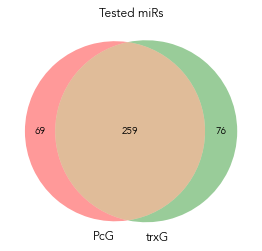

In [8]:
mpl.rcParams['font.family'] = 'Avenir'

subset_PcG_tested = set(PcG_enrch[PcG_enrch["n_geneset"] > 0].index)
subset_trxG_tested = set(trxG_enrch[trxG_enrch["n_geneset"] > 0].index)

venn2([subset_PcG_tested, subset_trxG_tested], ("PcG", "trxG"))
plt.title("Tested miRs", fontweight="bold")
plt.savefig("plots/tested_miRs.png", dpi = 500)
plt.show()

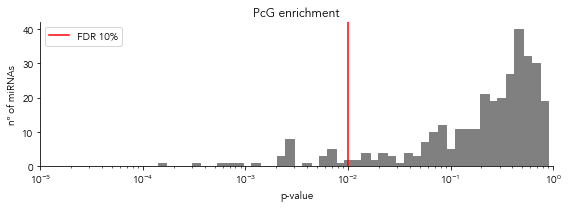

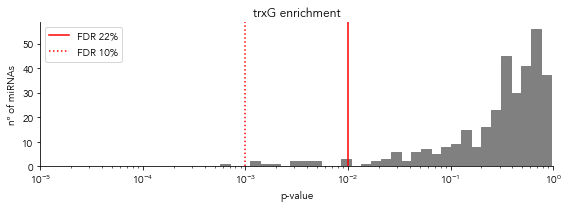

In [9]:
def plot_loghist(x, bins):
    """
    from https://stackoverflow.com/questions/47850202/
    plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, color= "grey", edgecolor= "grey")
    plt.xscale('log')


PcG_pvalues = PcG_enrch.loc[PcG_enrch["n_geneset"] > 0, "hyper_pval"]
trxG_pvalues = trxG_enrch.loc[trxG_enrch["n_geneset"] > 0, "hyper_pval"]


# PcG
mpl.rcParams['font.family'] = 'Avenir'
fig = plt.figure(figsize=(8, 3))
plt.title("PcG enrichment", fontweight = "bold")
plot_loghist(PcG_pvalues, bins=50)
plt.axvline(x = 0.01, color = "r", label = "FDR 10%")
plt.xlim(10**(-5),1)
#plt.xscale("log")

plt.legend(loc = "upper left")
plt.xlabel("p-value")
plt.ylabel("nº of miRNAs")
sns.despine()
plt.tight_layout()
plt.savefig("plots/PcG_enrichmentplot.png", dpi = 500, transparent = True)
plt.show()

# trxG
mpl.rcParams['font.family'] = 'Avenir'
fig = plt.figure(figsize=(8, 3))
plt.title("trxG enrichment", fontweight = "bold")
plot_loghist(trxG_pvalues, bins=50)
plt.axvline(x = 0.01, color = "r", label = "FDR 22%")
plt.axvline(x = 0.001, color = "r",linestyle=":", label = "FDR 10%")

plt.xlim(10**(-5),1)
#plt.xscale("log")

plt.legend(loc = "upper left")
plt.xlabel("p-value")
plt.ylabel("nº of miRNAs")
sns.despine()
plt.tight_layout()
plt.savefig("plots/trxG_enrichmentplot.png", dpi = 500, transparent = True)
plt.show()




Text(0.5, 1.0, 'miRNAs Fisher ORs')

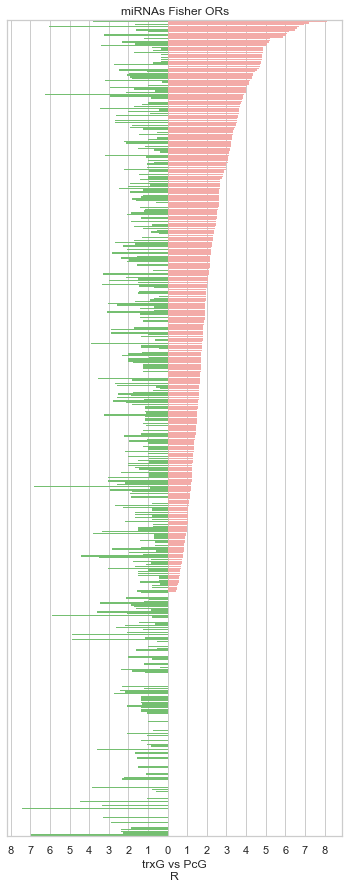

In [10]:
# Fig1
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))


# Plot the PcG Rs
sns.set_color_codes("pastel")
all(PcG_enrch.index == trxG_enrch.index)

order = PcG_enrch.sort_values("OR",ascending = False).index
sns.barplot(x="OR", y=order, data=PcG_enrch.loc[order,],
            label="Total", color="r",edgecolor='none')


# Plot the crashes where alcohol was involved
trxG_enrch_tmp = trxG_enrch.loc[order,].copy()
trxG_enrch_tmp["OR"] = - trxG_enrch_tmp["OR"]
sns.set_color_codes("muted")
sns.barplot(x="OR", y=order, data=trxG_enrch_tmp.loc[order,],
            label="Total", color="g", edgecolor='none')

ax.set_xticks(range(-8,9)) # <--- set the ticks first
ax.set_xticklabels([abs(ele) for ele in range(-8,9)])
ax.axes.get_yaxis().set_visible(False)
plt.xlabel("trxG vs PcG\nR")

## Add a legend and informative axis label
plt.title("miRNAs Fisher ORs")

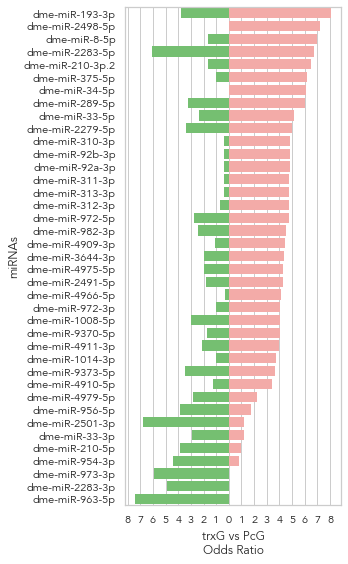

In [11]:
# Fig1 (subset of best genes)
sns.set_theme(style="whitegrid")
mpl.rcParams['font.family'] = 'Avenir'

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5, 8))


# Plot the PcG/trxG Rs that are significative
sns.set_color_codes("pastel")
all(PcG_enrch.index == trxG_enrch.index)
subset = ((PcG_enrch["hyper_pval"] < 0.01) | (trxG_enrch["hyper_pval"] < 0.01))
order = PcG_enrch[subset].sort_values("OR",ascending = False).index
sns.barplot(x="OR", y=order, data=PcG_enrch[subset].loc[order,],
            label="Total", color="r",edgecolor='none')


# add trxG Rs of those miRNAs
trxG_enrch_tmp = trxG_enrch[subset].loc[order,].copy()
trxG_enrch_tmp["OR"] = - trxG_enrch_tmp["OR"]
sns.set_color_codes("muted")
sns.barplot(x="OR", y=order, data=trxG_enrch_tmp.loc[order,],
            label="Total", color="g", edgecolor='none')

ax.set_xticks(range(-8,9)) # <--- set the ticks first
ax.set_xticklabels([abs(ele) for ele in range(-8,9)])
#ax.axes.get_yaxis().set_visible(False)
plt.xlabel("trxG vs PcG\nOdds Ratio")

## Add a legend and informative axis label
plt.title("")
plt.tight_layout()
plt.savefig("plots/bestPcG_OR.png", dpi = 500, transparent = True)

In [12]:
# Save in the final files
## Raw, for integration with PREs
trxG_enrch.to_csv("output_files/HCImiRTps_results/trxG_miRNAs.tsv", sep="\t")
trxG_core_enrch.to_csv("output_files/HCImiRTps_results/trxG_core_miRNAs.tsv", sep="\t")
PcG_enrch.to_csv("output_files/HCImiRTps_results/PcG_miRNAs.tsv", sep="\t")

### Multiple hypothesis correction
Performed by the R script "output_files/HCImiRTps_results/FDR_study.R" and results saved in the FDR/ directory in the same path

In [14]:
PcG_FDR = pd.read_csv("output_files/HCImiRTps_results/FDR/PcG_FDR_results.tsv", sep = "\t")
PcG_FDR

,miRNAs,n_geneset,OR,hyper_pval,rFDRc_q
0,dme-bantam-3p,1,2.123360,0.387067,0.636243
1,dme-bantam-5p,4,2.654699,0.087764,0.351383
2,dme-let-7-3p,6,2.063379,0.114750,0.412198
3,dme-let-7-5p,1,2.959550,0.297309,0.572266
4,dme-miR-1-3p,1,0.909418,0.675658,0.719985
...,...,...,...,...,...
323,dme-miR-9c-5p,3,2.038878,0.210362,0.523776
324,dme-miR-iab-4-3p,1,0.875753,0.689459,0.721930
325,dme-miR-iab-4-5p,1,0.850234,0.699320,0.724684
326,dme-miR-iab-8-3p,1,0.810684,0.715405,0.726490


In [15]:
trxG_FDR = pd.read_csv( "output_files/HCImiRTps_results/FDR/trxG_FDR_results.tsv", sep = "\t")
trxG_FDR

,miRNAs,n_geneset,OR,hyper_pval,rFDRc_q
0,dme-miR-2283-5p,19,6.060922,0.000012,0.004173
1,dme-miR-2501-3p,6,6.806691,0.000648,0.091787
2,dme-miR-956-5p,11,3.889702,0.001209,0.107745
3,dme-miR-973-3p,6,5.888976,0.001310,0.109627
4,dme-miR-2283-3p,7,4.889004,0.001677,0.112143
...,...,...,...,...,...
330,dme-miR-92b-3p,1,0.355472,0.937492,0.886681
331,dme-miR-92a-3p,1,0.354876,0.937766,0.887022
332,dme-miR-311-3p,1,0.354281,0.938040,0.887361
333,dme-miR-313-3p,1,0.353098,0.938583,0.887699


In [16]:
trxG_core_FDR = pd.read_csv( "output_files/HCImiRTps_results/FDR/trxG_core_FDR_results.tsv", sep = "\t")
trxG_core_FDR

,miRNAs,n_geneset,OR,hyper_pval,rFDRc_q
0,dme-let-7-3p,3,2.887284,0.145116,0.475803
1,dme-miR-10-5p,1,11.425044,0.095465,0.422938
2,dme-miR-100-5p,1,24.843810,0.045283,0.323468
3,dme-miR-1000-3p,1,2.048956,0.417295,0.545092
4,dme-miR-1000-5p,1,0.771289,0.743684,0.639721
...,...,...,...,...,...
175,dme-miR-997-3p,1,4.040179,0.242987,0.520545
176,dme-miR-999-3p,1,2.120428,0.406213,0.540632
177,dme-miR-9b-3p,1,4.068379,0.241079,0.519855
178,dme-miR-9c-3p,1,1.563882,0.504589,0.582909


## HCPREps distace to PRE Analysis

### Data loading

In [19]:
HCPREps = pd.read_csv(
    "../HCPREps_generation/output_files/HCPREps.gff", sep = "\t")

# miRNA genomic coordinates(hairpin and mature)
raw_miRs = pd.read_csv(
    "input_files/dme_miRBase.gff3",
    index_col=False, header=None,
    sep = "\t",skiprows=13)

raw_miRs.columns = ["chr", "noth0", "type", "start", "stop", 
                    "noth1", "strand", "noth2", "info"]

### Preprocessing

In [20]:
# RM empty columns
raw_miRs.drop(columns = ["noth0", "noth1", "noth2"], 
              errors="ignore", inplace=True)  

# adaptation of chr column
raw_miRs["chr"] = raw_miRs["chr"].apply(lambda x: x.strip("chr"))

# Filter
raw_miRs = raw_miRs.loc[raw_miRs["chr"].isin(HCPREps["chr"].drop_duplicates())] #miRNAs located in other scaffolds
hairpins = raw_miRs.loc[raw_miRs["type"]== "miRNA_primary_transcript",
                      ["chr", "start", "stop", "strand", "info"]].copy()          #only keep miRNA hairpins

### TSS distance to the closest PRE calculation

In [21]:
# Function definition
def Distance_TSS(gene, PRE):
    """
    calculate the TSS distance to a given interval
    TSS determined acording to strand, if hairpin falls in "+"
    "start" is the TSS, if hairpin falls in "-" "stop" is.
    
    - PRE     HCPREps prediction with coordinates ["start", "stop",...]
    - gene    the miRNA hairpin you whant to know the distance. 
                first fields have to be "start" and "stop"
    
    """
    gene_TSS = gene[0] if gene[2] == "+" else gene[1]
    if PRE[0]<= gene_TSS <= PRE[1]:
        return int(0)
    
    elif PRE[0] > gene_TSS:
        return int(PRE[0]-gene_TSS)
    
    elif gene_TSS > PRE[1]:
        return int(gene_TSS-PRE[1])
    
    
    
def ClosestPRE(miRNAs, PREs):
    """
    Function that index each miRNA hairpin  two the 2 closest PREs,
    and afterwards calculates the distance to each acording to its TSS using Distance_TSS(), 
    selecting the closest one as the miRNA closest PRE.
    
    - miRNAs: Dataframe containing the hairpin miRNA name and genomic location
    - PREs: HCPREps dataframe
    """
    # Sorting needed for the 
    miRNAs.sort_values(by=["chr", "start"], inplace=True)
    PREs.sort_values(by=["chr", "start"], inplace=True)
    # chromosome scaffold iteration
    for ch in PREs["chr"].drop_duplicates():
        PREs_subset = PREs.loc[PREs["chr"] == ch, ["start", "stop", "score_kf19"]]
        miRNAs_subset = miRNAs.loc[miRNAs["chr"] == ch, ["start", "stop", "strand"]]
        
        # selection of closest PREs by checking the position of miRNAs inside PRE ordered df
        positions = PREs_subset["start"].searchsorted(miRNAs_subset["start"])
        
        # loop selecting the closest among the 2 closest PREs
        i=0
        for ind in miRNAs_subset.index:
            miR = miRNAs_subset.loc[ind,:]

            if positions[i] == 0:
                ## If assigned position is 0 the only PRE is the closest
                pos = positions[i]
                d = Distance_TSS(miR, PREs_subset.iloc[pos])
                
            elif positions[i] == PREs_subset.shape[0]:
                pos = positions[i]-1
                d = Distance_TSS(miR, PREs_subset.iloc[pos])
                
                
            else:
                ### distance calculation
                pos_1 = positions[i]-1
                pos_2 = positions[i]
                d1 = Distance_TSS(miR, PREs_subset.iloc[pos_1])
                d2 = Distance_TSS(miR, PREs_subset.iloc[pos_2])

                ## Election of the closest
                argmin = np.argmin((d1,d2))
                d = [d1,d2][argmin]
                pos = [pos_1, pos_2][argmin]


            ## saving of information
            pre_coords = PREs_subset.iloc[[pos]][["start", "stop"]].astype("str").agg("..".join, axis = 1).values
            miRNAs.loc[ind,"PRE"] = ch+":"+pre_coords
            miRNAs.loc[ind,"score_kf19"] = PREs_subset.iloc[pos]["score_kf19"]
            miRNAs.loc[ind,"distance"] = d
            i+=1
        
    return miRNAs


# Application
miRNA_PREs = ClosestPRE(hairpins, HCPREps)

# Post processing
miRNA_PREs[["ID", "Alias", "Name"]] = miRNA_PREs["info"].str.split(";",expand=True)
miRNA_PREs.drop(columns= ["Alias", "info"], inplace = True, errors="ignore")
miRNA_PREs["ID"] = miRNA_PREs["ID"].apply(lambda x: x.strip("ID="))
miRNA_PREs["Name"] = miRNA_PREs["Name"].apply(lambda x: x.strip("Name="))
miRNA_PREs.sort_values(by= ["distance"])
miRNA_PREs.set_index("Name", inplace = True)

# Export
miRNA_PREs.to_csv("output_files/HCPREps_results/miRNA_closest_PREs.tsv", sep = "\t")

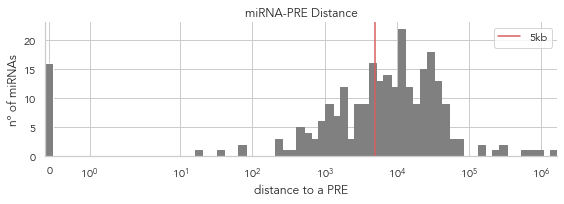

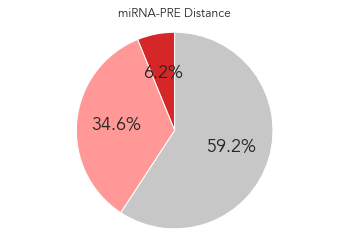

In [24]:
# prints

# Plots
## Histogram
### Function
def plot_loghist(x, bins):
    """
    Adapted from https://stackoverflow.com/questions/47850202/
    plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, color= "grey", edgecolor= "grey")
    plt.xscale('symlog')


    
    
#### Plot perse    
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 12

fig1, ax1 = plt.subplots(figsize=(8, 3))
plt.title("miRNA-PRE Distance", fontweight = "bold")


plot_loghist(miRNA_PREs.loc[miRNA_PREs["distance"]>0, "distance"].dropna()+1,
             bins=50)

plt.hist(miRNA_PREs.loc[miRNA_PREs["distance"]==0, "distance"].dropna(),
             bins=5, color= "grey")

ax1.axvline(x = 5000, color = "r", label = "5kb")

plt.xlim(-0.1,max(miRNA_PREs["distance"]))


plt.legend(loc = "upper right")
plt.xlabel("distance to a PRE")
plt.ylabel("nº of miRNAs")
sns.despine()
plt.tight_layout()
plt.savefig("plots/miRNA_dist_hist.png", dpi = 500, transparent = True)
plt.show()



## Pie chart

### calculatipnss
zero = sum(miRNA_PREs["distance"] == 0)
lt5kb = sum(miRNA_PREs["distance"] <= 5000) - zero
mt5kb = sum(miRNA_PREs["distance"] > 5000)

## Plot perse
mpl.rcParams['font.size'] = 18
labels = 'overlaping', '(non overlapping)\nless than 5kb', '(non overlapping)\nmore than 5kb'
sizes = [zero, lt5kb, mt5kb]
explode = (0, 0, 0)  
cmap = plt.get_cmap("tab20")
colors = cmap(np.array([6,7,15]))

fig1, ax1 = plt.subplots()
ax1.set_title("miRNA-PRE Distance", fontweight = "bold")
ax1.pie(sizes, explode=explode, labels= None, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("plots/miRNA_dist_pie.png", dpi = 500, transparent = True)

plt.show()

## Integration of mature miRNA PcG/trxG enrichment and pre-miRNA PRE distance for the unvailing of PcG/trxG crosstalking miRNAs


### Construction of mature miRNA:hairpin connection table


In [25]:
hair_mat_connection = pd.DataFrame(columns = ["hairpin", "h_name", "mature", "m_name"])

with open("input_files/miRNA.dat") as infile:
    dme = False
    i = 0
    for line in infile:
        
        # condicional para ver si es de dmel
        ## Si no es dmel atajo para no procesar nada 
        if dme == False:
            
            ### primera linea de cada entrada nos dice organismo. si es dmel cambiamos el switch
            if line[0:9] == "ID   dme-":
                dme = True 
                h_name = line.split("   ")[1] # y guardamos el nombre pal futuro
                continue
                
            ### si no es dmel siguiente linea
            else:
                dme = False
                continue
                
        ## si es de dmel dme = True y ahora revisamos las siguientes lineas por los nombres maduros
        else:
            code = line[0:2]
            if code == "AC":
                hairpin = line[5:-2] # guardamos el accession number como hairpin
            
            ### revisamos que empiece por FT
            if code == "FT":
                #### Si es asi revisamos que sea la linea del nombre maduro, y si lo es creamos una entrada en el df fina
                    
                if line[21:32] == "/accession=":
                    mature = line[33:-2]
                if line[21:30] == "/product=":
                    m_name = line[31:-2]
                    hair_mat_connection.loc[i,["hairpin","h_name", "mature", "m_name"]] = hairpin,h_name, mature, m_name
                    i+=1
                #### si no lo fuese revisamos la siguiente linea    
                else:
                    continue
            
            ## si empieza en su lugar por // significa que se pasa a la siguiente entrada, asique dme = False
            elif code == "//":
                dme = False
                continue
                
            
            
hairpin_mature = hair_mat_connection            

### Integration

In [26]:
# Addition of hairpin ID to PcG/trxG/core_trxG mature miRNA enrichment results
integrated_PcG = PcG_enrch.join(hairpin_mature.set_index(["m_name"]))
integrated_trxG = trxG_enrch.join(hairpin_mature.set_index(["m_name"]))
integrated_trxG_core = trxG_core_enrch.join(hairpin_mature.set_index(["m_name"]))

# Manual addition of miR 210 3p mature miRNAs (dme-miR-210-3p.1 and .2)
harp_210_3p = hairpin_mature.loc[hairpin_mature["m_name"]== "dme-miR-210-3p", ["hairpin", "mature", "h_name"]]

integrated_PcG.loc["dme-miR-210-3p.1", ["hairpin", "mature", "h_name"]] = harp_210_3p.values.flatten()
integrated_PcG.loc["dme-miR-210-3p.2", ["hairpin", "mature", "h_name"]] = harp_210_3p.values.flatten()

integrated_trxG.loc["dme-miR-210-3p.1", ["hairpin", "mature",  "h_name"]] = harp_210_3p.values.flatten()
integrated_trxG.loc["dme-miR-210-3p.2", ["hairpin", "mature",  "h_name"]] = harp_210_3p.values.flatten()

integrated_trxG_core.loc["dme-miR-210-3p.1", ["hairpin", "mature",  "h_name"]] = harp_210_3p.values.flatten()
integrated_trxG_core.loc["dme-miR-210-3p.2", ["hairpin", "mature",  "h_name"]] = harp_210_3p.values.flatten()

# Junction of PRE distance results
integrated_PcG = integrated_PcG.join(miRNA_PREs.set_index(["ID"]), on= "hairpin")
integrated_trxG = integrated_trxG.join(miRNA_PREs.set_index(["ID"]), on= "hairpin")
integrated_trxG_core = integrated_trxG_core.join(miRNA_PREs.set_index(["ID"]), on= "hairpin")

In [27]:
# problematic miRNAs
#print(np.all(integrated_PcG.index==integrated_trxG_core.index)) # same index for all integrated_PcG, trxG core_trxG
p_mat = integrated_PcG[~integrated_PcG.index.isin(hairpin_mature["m_name"])].index
p_hair = hairpin_mature[~hairpin_mature["m_name"].isin(integrated_PcG.index)]["h_name"].values

print('\033[95m'+ "problematic mature miRNAs" + '\033[0m')
display(p_mat)
print('\n\n \033[95m'+ "problematic miRNAs hairpins" + '\033[0m')
display(p_hair)

problematic mature miRNAs


Index(['dme-miR-210-3p.1', 'dme-miR-210-3p.2', 'dme-miR-2a-2/2c'], dtype='object')



 problematic miRNAs hairpins


array(['dme-mir-210', 'dme-mir-10404', 'dme-mir-10404', 'dme-mir-11182'],
      dtype=object)

### Analysis

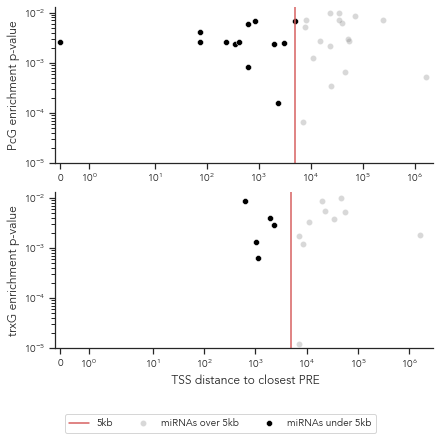

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# calculations
integrated_enriched_PcG = integrated_PcG[integrated_PcG["hyper_pval"] < 0.01]
integrated_enriched_trxG = integrated_trxG[integrated_trxG["hyper_pval"] < 0.01]


# plot settings
sns.set_style("ticks")
mpl.rcParams['font.family'] = 'Avenir'

## Ajustar fontsizes
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    

#plot perse
fig1 = plt.figure(constrained_layout=True, figsize=(6, 6))
gs1 = fig1.add_gridspec(nrows=9, ncols=2, left=0.05, right=0.48, wspace=0.05)

## PcG 
f1_ax1 = fig1.add_subplot(gs1[0:4, :])
sns.scatterplot(x = integrated_enriched_PcG.loc[integrated_enriched_PcG["distance"] > 5000, "distance"],
            y = integrated_enriched_PcG.loc[integrated_enriched_PcG["distance"] > 5000,"hyper_pval"],
            color = "grey", alpha = 0.3, ax = f1_ax1, label = "miRNAs over 5kb")

sns.scatterplot(x = integrated_enriched_PcG.loc[integrated_enriched_PcG["distance"] <= 5000, "distance"],
            y = integrated_enriched_PcG.loc[integrated_enriched_PcG["distance"] <= 5000,"hyper_pval"],
            color = "black", alpha = 1, ax = f1_ax1, label = "miRNAs under 5kb")

## trxG
f1_ax2 = fig1.add_subplot(gs1[4:8, :])
sns.scatterplot(x = integrated_enriched_trxG.loc[integrated_enriched_trxG["distance"] > 5000,"distance"],
            y = integrated_enriched_trxG.loc[integrated_enriched_trxG["distance"] > 5000,"hyper_pval"],
            color = "grey", alpha = 0.3, ax = f1_ax2, label = "miRNAs over 5kb")

sns.scatterplot(x = integrated_enriched_trxG.loc[integrated_enriched_trxG["distance"] <= 5000,"distance"],
            y = integrated_enriched_trxG.loc[integrated_enriched_trxG["distance"] <= 5000,"hyper_pval"],
            color = "black", alpha = 1, ax = f1_ax2, label = "miRNAs under 5kb")


#ax1.set_title("PcG microRNAs", fontweight = "bold")
#ax2.set_title("trxG microRNAs", fontweight = "bold")

f1_ax1.set_ylim(10**(-5), 0.013)
f1_ax2.set_ylim(10**(-5), 0.013)


f1_ax1.set_xlim(-0.2,f1_ax1.get_xlim()[1]*1.3)
f1_ax2.set_xlim(-0.2,f1_ax1.get_xlim()[1]*1.3)

f1_ax1.set_yscale('log')
f1_ax2.set_yscale('log')


f1_ax1.set_xscale('symlog')
f1_ax2.set_xscale('symlog')


f1_ax1.axvline(x = 5000, color = "r", label = "5kb")
f1_ax2.axvline(x = 5000, color = "r", label = "5kb")


f1_ax1.set_xlabel("")
f1_ax2.set_xlabel(" TSS distance to closest PRE")

f1_ax1.set_ylabel("PcG enrichment p-value")
f1_ax2.set_ylabel("trxG enrichment p-value")

handles, labels = f1_ax1.get_legend_handles_labels()
f1_ax1.legend_.remove()
f1_ax2.legend_.remove()
fig1.legend(handles, labels, loc = "lower center", ncol=3)


sns.despine()
plt.savefig("plots/enrichedmiRNA_distance.png", dpi = 500, transparent = True)
plt.show()

In [31]:
# tables
circuits_PcG = integrated_enriched_PcG.loc[integrated_enriched_PcG["distance"] <= 5000,
                                         ["n_geneset", "OR", "hyper_pval", "distance"]]

circuits_trxG = integrated_enriched_trxG.loc[integrated_enriched_trxG["distance"] <= 5000,
                                         ["n_geneset",  "OR", "hyper_pval", "distance"]]
# column renaming
circuits_PcG.columns = ["nº of PcG \ntarget proteins",
                           "PcG enrichment \nOR", "PcG enrichment \np-value", "TSS distance to \nclosest PRE"]

circuits_trxG.columns = ["nº of trxG \ntarget proteins",
                           "trxG enrichment \nOR", "trxG enrichment \np-value", "TSS distance to \nclosest PRE"]

# export to cxv
circuits_PcG.to_csv("plots/circuits_PcG.tsv", sep= "\t")
circuits_trxG.to_csv("plots/circuits_trxG.tsv", sep= "\t")

display(circuits_PcG)
display(circuits_trxG)

,nº of PcG \ntarget proteins,PcG enrichment \nOR,PcG enrichment \np-value,TSS distance to \nclosest PRE
dme-miR-210-3p.2,5,6.492708,0.002361,1952.0
dme-miR-2498-5p,4,7.213554,0.004034,75.0
dme-miR-289-5p,15,6.049022,0.000158,2329.0
dme-miR-310-3p,7,4.873407,0.002348,356.0
dme-miR-311-3p,7,4.795686,0.002552,236.0
dme-miR-312-3p,7,4.767611,0.00263,75.0
dme-miR-313-3p,7,4.779607,0.002597,0.0
dme-miR-375-5p,4,6.161937,0.006877,4942.0
dme-miR-4910-5p,10,3.402419,0.006929,870.0
dme-miR-92a-3p,7,4.803762,0.00253,423.0


,nº of trxG \ntarget proteins,trxG enrichment \nOR,trxG enrichment \np-value,TSS distance to \nclosest PRE
dme-miR-210-5p,8,3.830315,0.003859,1952.0
dme-miR-2501-3p,6,6.806691,0.000645,1137.0
dme-miR-289-5p,16,3.225046,0.002823,2329.0
dme-miR-972-5p,15,2.76001,0.008545,635.0
dme-miR-973-3p,6,5.888976,0.001318,1011.0


### Further comparison between PcG and trxG cross-talking miRNAs
A first step substituting the "NaN" enrichment p-value of non tested miRNAs (for not having any gene set gene as target) to 1 is needed for the generation of the plots of this part.

In [32]:
# Dataframe preparation
values = {"hyper_pval": 1} 
plots_PcG = integrated_PcG.fillna(values)
plots_trxG = integrated_trxG.fillna(values) 

#### **Figure 3**: miRNAs involved in Polycomb, trithorax and shared regulatory circuits
with the limits of the criteria decided to be considered as involved in regulatory circuits in red.
Colored by the regulatory circuit with:
- PcG as red
- trxG as green
- shared as blue

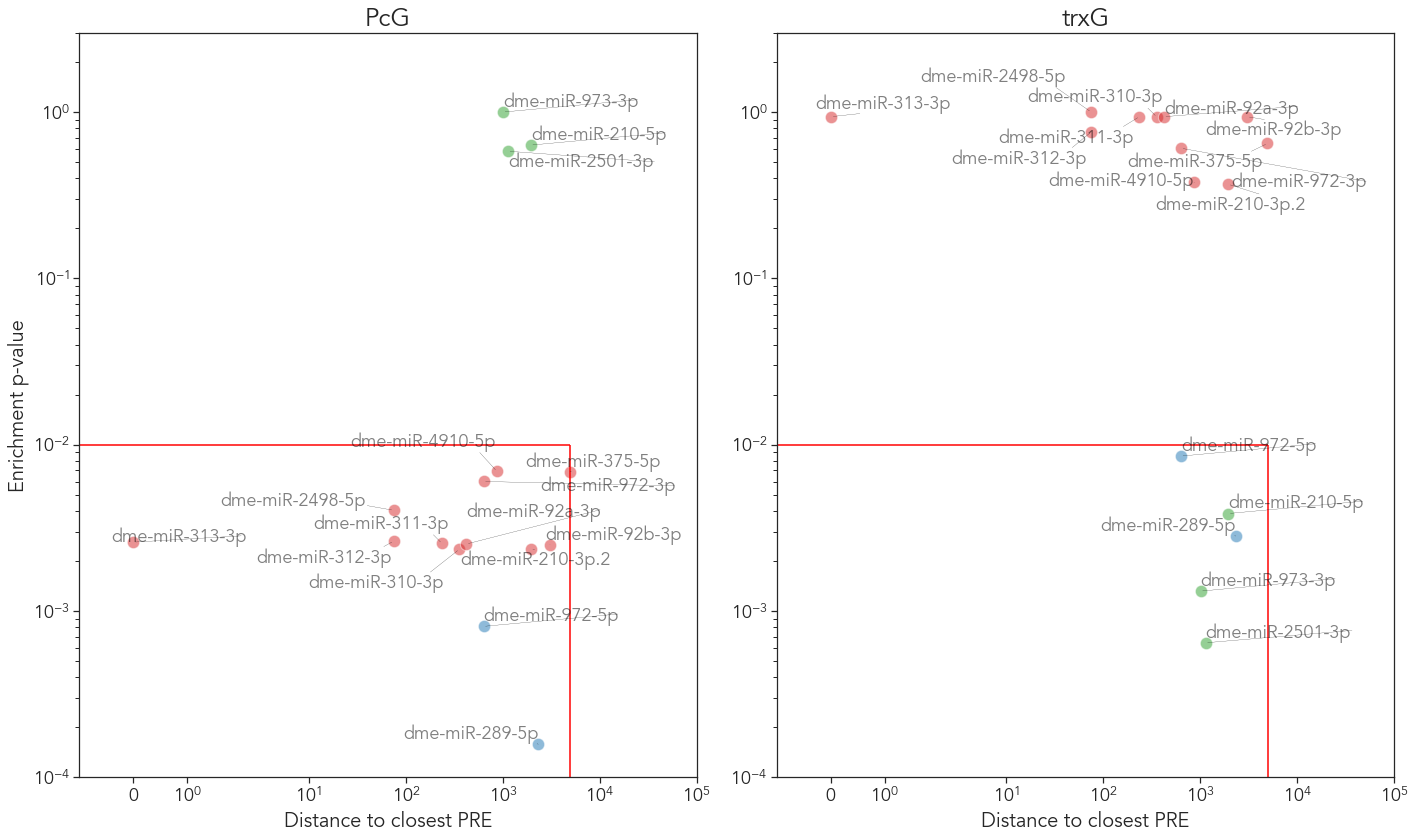

In [50]:
# Plotting function definition
def Plot_names(data, ax):
    texts = []
    for line in range(0,data.shape[0]):
        texts.append(ax.text(data.distance[line]+0.01,
                 data.hyper_pval[line],
                 data.index[line], horizontalalignment='left',
                 size='medium', color='black', alpha=0.5, fontweight= "normal"))
    
    adjust_text(texts, ax=ax, autoalign="xy",precision=0.001,
                expand_text=(1.01, 1.05), expand_points=(1.01, 1.05),
                force_text=(0.03, 0.35), force_points=(0.01, 0.3),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.2))

def Plot_significative(PcG, trxG, dist_th = 5000, pval_th = 0.01, log_scale = False):

    # Data preparation
    trxG = trxG.copy()    
    PcG = PcG.copy()
    
    sign_PcG = PcG.loc[(PcG["distance"]<dist_th) &
                       (PcG["hyper_pval"]<pval_th)]
    
    sign_trxG = trxG.loc[(trxG["distance"]<dist_th) &
                         (trxG["hyper_pval"]<pval_th)]
    # Plot
    
    ## Ajust fontsizes
    mpl.rcParams['font.family'] = 'Avenir'
    SMALL_SIZE = 18
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 25

    plt.rc('font', size=18)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,12))
        
    ## Plotting loop
    for sign_dataset, name in zip([sign_PcG, sign_trxG], ["PcG", "trxG"]):
        
        ### Dataset selection
        if name == "PcG": 
            ax = ax1
            sign_other = PcG.loc[sign_trxG.index,:]
            isinother = sign_PcG.index.isin(sign_other.index)
            common = sign_PcG[isinother]
            group = sign_PcG[~isinother]
            other = sign_other.drop(index = common.index)
            col = "tab:red"
            other_col = "tab:green"
            
        elif name == "trxG":
            ax = ax2
            sign_other = trxG.loc[sign_PcG.index,:]
            isinother = sign_trxG.index.isin(sign_other.index)
            common = sign_trxG[isinother]
            group = sign_trxG[~isinother]
            other = sign_other.drop(index = common.index)
            col = "tab:green"
            other_col = "tab:red"
   
        ### Plotting  
        ax.set_title(name, fontweight = "bold", fontsize = 25)      
        
        sns.scatterplot(x = group["distance"],
                y = group["hyper_pval"],
                color = col, alpha = 0.5, ax = ax, s=150)
        

        sns.scatterplot(x = other["distance"],
                y = other["hyper_pval"],
                color = other_col, alpha = 0.5, ax = ax, s=150)
           
            
        sns.scatterplot(x = common["distance"],
                y = common["hyper_pval"],
                color = "tab:blue", alpha = 0.5, ax = ax, s=150)
                        
        ### Aesthetic adjustment
        ### lines
        ax.vlines(dist_th,0,pval_th, color = "red")
        ax.hlines(pval_th,-1,dist_th, color = "red")
        
        ### scale
        ax.set_xscale("symlog")
        ax.set_yscale("log")
        
        ### Limits
        ax.set_xlim(-1,10**(5))
        ax.set_ylim(10**(-4),3)
        
        ### Labels
        ax.set_xlabel("Distance to closest PRE")
        ax1.set_ylabel("Enrichment p-value")
        ax2.set_ylabel("")
      
        # miRNA name addition
        Plot_names(group, ax)
        Plot_names(common, ax)
        Plot_names(other, ax)
        
        
    sns.set_style("ticks")
    plt.tight_layout()
    plt.savefig("plots/figure_pvalue_distances.png", dpi = 200, transparent = True)
    plt.show()
    
# Plotting function calling
Plot_significative(plots_PcG, plots_trxG, log_scale=False)

### Generation of Table 3 and Supplementary Table X

In [53]:

def Summary_table_creator(PcG, trxG, genesets_info, CWCS_matrix, trxG_core = False, dist_th = 5000, pval_th = 0.01):
    """
    """
    gene_sets, PcG_subset, trxG_subset, trxGcore_subset = genesets_info
    best_PcG = PcG[(PcG.distance < dist_th)&(PcG.hyper_pval < pval_th)]
    best_trxG = trxG[(trxG.distance < dist_th)&(trxG.hyper_pval < pval_th)]

    sign_hairpins = pd.concat([best_PcG.h_name, best_trxG.h_name]).drop_duplicates().values
    target_table = pd.DataFrame(index = PcG.index)
    target_table.sort_index(inplace = True)
    
    for hairpin in sign_hairpins:
        PcG_entries = PcG.loc[PcG.h_name == hairpin,:]
        trxG_entries = trxG.loc[trxG.h_name == hairpin,:]
        
        # general
        target_table.loc[PcG_entries.index.values, "Hairpin"] = PcG_entries.loc[:,"h_name"]
        target_table.loc[PcG_entries.index.values, "Distance_PRE"] = PcG_entries.loc[:,"distance"]
        target_table.loc[PcG_entries.index.values, "PRE"] = PcG_entries.loc[:,"PRE"]
        target_table.loc[PcG_entries.index.values, "score_kf19"] = PcG_entries.loc[:,"score_kf19"]
        
        #pvalues
        target_table.loc[PcG_entries.index.values, "PcG_OR"] = PcG_entries["OR"]
        target_table.loc[PcG_entries.index.values, "PcG_pval"] = PcG_entries["hyper_pval"]
        target_table.loc[trxG_entries.index.values, "trxG_OR"] = trxG_entries["OR"]
        target_table.loc[trxG_entries.index.values, "trxG_pval"] = trxG_entries["hyper_pval"]

        if isinstance(trxG_core, bool): 
            pass
        else:
            trxG_core_entries = trxG_core.loc[trxG_core.h_name == hairpin,:]
            target_table.loc[trxG_core_entries.index.values, "trxG_core_pval"] = trxG_core_entries["hyper_pval"]


        
        #proteins and  scores
        for mature in PcG_entries.index:
            ## get gene_IDS, and select PcG/trxG
            present_IDs = CWCS_matrix[mature].dropna()
            PcG_IDs = present_IDs.loc[present_IDs.index.isin(gene_sets["PcG"])]
            trxG_IDs = present_IDs.loc[present_IDs.index.isin(gene_sets["trxG"])]
            
            ## get info of PcG/trxG IDs
            PcG_info = PcG_subset.loc[PcG_subset["ID"].isin(PcG_IDs.index),["ID", "Name", "Complex"]]
            trxG_info = trxG_subset.loc[trxG_subset["ID"].isin(trxG_IDs.index),["ID", "Name", "Complex"]]

            PcG_info = PcG_info.join(PcG_IDs, on="ID")
            trxG_info = trxG_info.join(trxG_IDs, on="ID")
            
            ## Use info for puting score and complexes
            PcG_complex = ", ".join(PcG_info["Complex"].drop_duplicates())
            trxG_complex = ", ".join(trxG_info["Complex"].drop_duplicates())

            PcG_genescores = [(e[0] + " [" + str(format(e[1], '.3f')) + "]")
                              for e in PcG_info[["Name", mature]].drop_duplicates().values]

            trxG_genescores = [(e[0] + " [" + str(format(e[1], '.3f')) + "]")
                          for e in trxG_info[["Name", mature]].drop_duplicates().values]

            ## add to table
            target_table.loc[mature, "PcG_complex"] = PcG_complex
            target_table.loc[mature, "PcG_genes"] = " ,\n ".join(PcG_genescores)
            target_table.loc[mature, "trxG_complex"] = trxG_complex
            target_table.loc[mature, "trxG_genes"] = " ,\n ".join(trxG_genescores)

    return target_table.dropna(how = "all")

# Table 2
summary_table_crosstalking = Summary_table_creator(integrated_PcG, integrated_trxG,
                                    genesets_info= [gene_sets, PcG_subset, trxG_subset, trxGcore_subset],
                                    CWCS_matrix = CWCS_matrix)

summary_table_crosstalking.to_csv("output_files/summary_table_crosstalking.tsv", sep = "\t")

# Supplementary Table 1
summary_table_complete = Summary_table_creator(integrated_PcG, integrated_trxG, trxG_core = False,
                                    genesets_info= [gene_sets, PcG_subset, trxG_subset, trxGcore_subset],
                                    CWCS_matrix = CWCS_matrix, dist_th = 10**10, pval_th = 1)

summary_table_complete.to_csv("output_files/summary_table_complete.tsv", sep = "\t")